To do: vmap forward and backward pass. Add regularization when needed.

In [1]:
import jax
from jax import numpy as np
from jax.lax import scan
from jax import vmap, jit
from jax import jacfwd, jacrev
import numpy as onp

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("RdYlBu", 8)
import time

import sys
sys.path.append("../src/")
import network_and_arm
import arm_model
from scipy.interpolate import interp1d
import ilqr_network_arm

/home/mkp127/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
with open("../data/network_s972356.pickle", 'rb') as handle:
    data = pickle.load(handle)
params = data['params']

N = 200
time_steps = 600
h0 = params['x0']
theta0 = np.array([10, 143.54]) * np.pi/180
q0 = np.concatenate((theta0, np.zeros((2, ))))
q0 = np.repeat(q0[None], axis=0, repeats=8)
x0 = np.concatenate((np.zeros((8, 2)), h0, q0), axis=1)

In [3]:
with open('../data/arm_dt10.pickle', 'rb') as handle:
    d = pickle.load(handle)
print(d.keys())
target_trj = d['states'][:,::2,:2]
#plt.plot(target_trj[0])

dict_keys(['torques', 'positions', 'states'])


In [4]:
prep = d['states'][:,0,:2][:,None].repeat(300, 1)
move = interp1d(np.arange(30), d['states'][:,::2,:2], axis=1, fill_value='extrapolate')(np.arange(0, 30, 0.1))
target_trj = np.concatenate((prep, move),1)
y_target = arm_model.get_position_batch(target_trj)


In [5]:
h0 = data['xsp'][None].repeat(8, 0)
theta0 = np.array([10, 143.54]) * np.pi/180
q0 = np.concatenate((theta0, np.zeros((2, ))))
q0 = np.repeat(q0[None], axis=0, repeats=8)
x0 = np.concatenate((np.zeros((8, 2)), h0, q0), axis=1)

In [6]:
from importlib import reload
reload(ilqr_network_arm)

<module 'ilqr_network_arm' from '../src/ilqr_network_arm.py'>

142


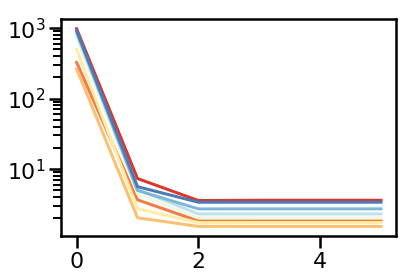

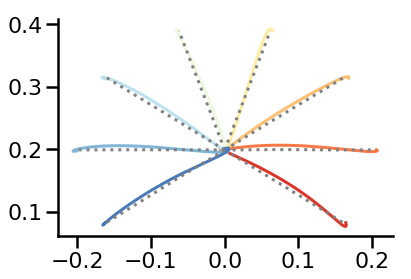

In [7]:
lmbda = 1e-4
regu = 0.0
t0 = time.time()
x_trj, u_trj, cost_trace = ilqr_network_arm.run_ilqr_batch(x0, target_trj, None, 5, regu, lmbda)
y_trj = arm_model.get_position_batch(x_trj[:,:,-4:-2]) 
t1 = time.time()
print(f"{t1-t0:1.0f}")
plt.semilogy(cost_trace.T)
plt.figure()
# Short
for i in range(8):
    plt.plot(y_trj[i,:,0],y_trj[i,:,1])
    plt.plot(y_target[i,:,0], y_target[i,:,1], ":",color='gray')
sns.despine()

In [8]:
np.linalg.norm(u_trj[:,:300])/np.linalg.norm(u_trj[:,300:])

DeviceArray(1.8811096, dtype=float32)

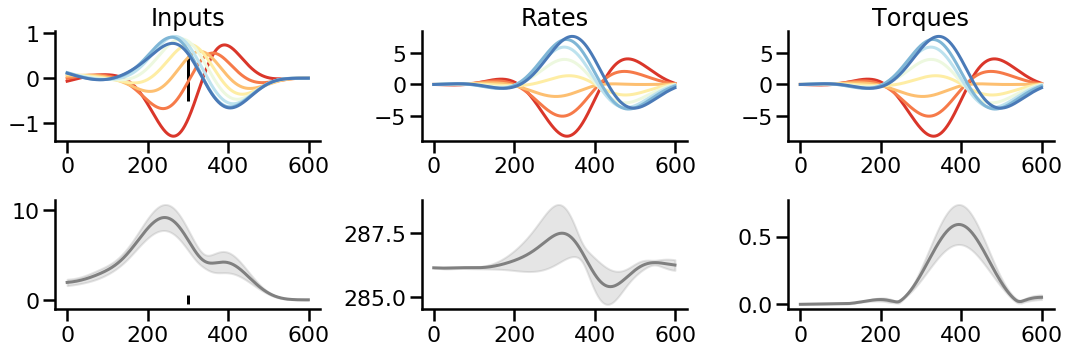

In [9]:
fig, ax = plt.subplots(2,3, figsize=(15,5))

ax[0,0].set_title("Inputs")
ax[0,1].set_title("Rates")
ax[0,2].set_title("Torques")


ax[0,0].plot(u_trj[:,:,0].T)
ax[0,0].vlines(300, -0.5, 0.5)
ax[1,0].plot(np.linalg.norm(u_trj, axis=(2)).mean(0),color='gray')
ax[1,0].fill_between(np.arange(600), np.linalg.norm(u_trj, axis=(2)).mean(0) -np.linalg.norm(u_trj, axis=(2)).std(0),
                    np.linalg.norm(u_trj, axis=(2)).mean(0) +np.linalg.norm(u_trj, axis=(2)).std(0), alpha=0.2, color='gray')
ax[1,0].vlines(300, -0.5, 0.5)

ax[0,1].plot(x_trj[:,:,0].T)
ax[1,1].plot(np.linalg.norm(x_trj[:,:,:-4], axis=2).mean(0), color='gray')
ax[1,1].fill_between(np.arange(600), np.linalg.norm(x_trj[:,:,:-4], axis=2).mean(0)-np.linalg.norm(x_trj[:,:,:-4], axis=2).std(0),
                     np.linalg.norm(x_trj[:,:,:-4], axis=2).mean(0)+np.linalg.norm(x_trj[:,:,:-4], axis=2).std(0), alpha=0.2, color='gray')

ax[0,2].plot(x_trj[:,:,0].T)
ax[1,2].plot(np.linalg.norm(x_trj[:,:,-2:], axis=2).mean(0), color='gray')
ax[1,2].fill_between(np.arange(600), np.linalg.norm(x_trj[:,:,-2:], axis=2).mean(0) -  np.linalg.norm(x_trj[:,:,-2:], axis=2).std(0),
                     np.linalg.norm(x_trj[:,:,-2:], axis=2).mean(0) +  np.linalg.norm(x_trj[:,:,-2:], axis=2).std(0), alpha=.2,color='gray')

#ax[1].plot()
sns.despine()
fig.tight_layout()

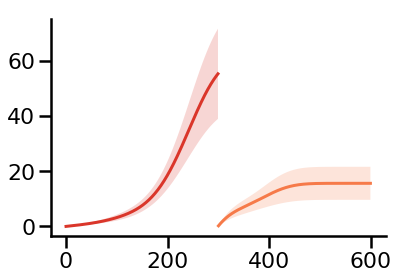

In [10]:
plt.plot(np.cumsum(np.mean(u_trj[:,:300]**2, axis=(2)), axis=1).mean(0))
plt.fill_between(np.arange(300), np.cumsum(np.mean(u_trj[:,:300]**2, axis=(2)), axis=1).mean(0) - np.cumsum(np.mean(u_trj[:,:300]**2, axis=(2)), axis=1).std(0),
                np.cumsum(np.mean(u_trj[:,:300]**2, axis=(2)), axis=1).mean(0) + np.cumsum(np.mean(u_trj[:,:300]**2, axis=(2)), axis=1).std(0), 
                alpha=0.2,)
plt.plot(np.arange(300, 600), np.cumsum(np.mean(u_trj[:,300:]**2, axis=(2)), axis=1).mean(0))
plt.fill_between(np.arange(300, 600), np.cumsum(np.mean(u_trj[:,300:]**2, axis=(2)), axis=1).mean(0) - np.cumsum(np.mean(u_trj[:,300:]**2, axis=(2)), axis=1).std(0),
                np.cumsum(np.mean(u_trj[:,300:]**2, axis=(2)), axis=1).mean(0) + np.cumsum(np.mean(u_trj[:,300:]**2, axis=(2)), axis=1).std(0), 
                alpha=0.2)

sns.despine()

# PCA

In [11]:
from sklearn.decomposition import PCA
n_pcs = 6
pca = PCA(n_pcs)

X = pca.fit_transform(x_trj[:,:,:N].reshape((-1, N))).reshape((8, 600, n_pcs))
print(pca.explained_variance_ratio_)

[0.48915967 0.23087946 0.14979747 0.05145552 0.03242667 0.01539944]


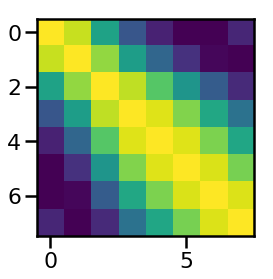

In [12]:
X0 = X[:,300]
plt.imshow(np.corrcoef(X0))

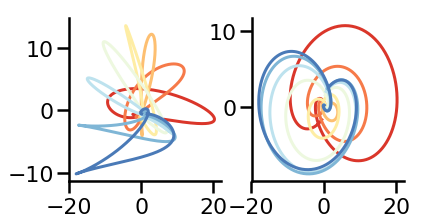

In [13]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(X[:,:,0].T, X[:,:,1].T)
ax[1].plot(X[:,:,0].T, X[:,:,2].T)
sns.despine()

# jPCA

In [15]:
import autograd.numpy as anp

from pymanopt.manifolds import SkewSymmetric
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent

X.shape
dx = np.diff(X[:,300:500], axis=1).reshape((-1, n_pcs))
x = X[:,300:500][:,:-1].reshape((-1, n_pcs))
print(dx.shape, x.shape)

manifold = SkewSymmetric(n_pcs)


def cost(M):
    return anp.mean((dx - x@M)**2)

# (3) Instantiate a Pymanopt solver
solver = SteepestDescent()
problem = Problem(manifold=manifold, cost=cost)

# let Pymanopt do the rest
Mopt = solver.solve(problem)
print(Mopt)

(1592, 6) (1592, 6)
Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	+3.7711776733398438e+01	3.17032601e+01
    2	+1.3532149314880371e+01	1.70434677e+01
    3	+2.7280814647674561e+00	6.67865652e+00
    4	+1.4820481538772583e+00	5.84391053e+00
    5	+4.3426427245140076e-01	1.90454039e+00
    6	+3.1270834803581238e-01	2.24172349e+00
    7	+1.9622628390789032e-01	1.61595634e+00
    8	+1.2635333836078644e-01	1.06801735e+00
    9	+1.1272361129522324e-01	1.29553353e+00
   10	+7.3571860790252686e-02	6.13031708e-01
   11	+5.7613961398601532e-02	5.69616821e-01
   12	+4.5622501522302628e-02	5.13240220e-01
   13	+3.6118831485509872e-02	4.28820543e-01
   14	+2.9398631304502487e-02	4.27917989e-01
   15	+2.2989777848124504e-02	2.75770337e-01
   16	+1.9194139167666435e-02	4.43285643e-01
   17	+1.4105472713708878e-02	2.78239375e-01
   18	+1.3241423293948174e-02	4.00718173e-01
   19	+1.0455243289470673e-02	2.50871457e-01
   20	+8.5581401363015175

In [16]:
evals, evecs = np.linalg.eig(Mopt)
Xpred = X@Mopt

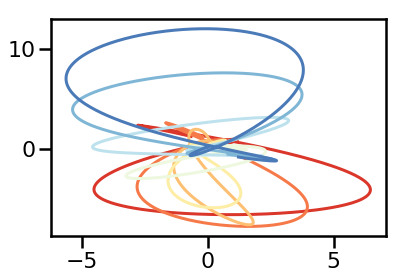

In [20]:
for i in range(8):
    #plt.plot(Xpred[i,:,0],Xpred[i,:,1])
    plt.plot((X@evecs[:,0])[i].real,(X@evecs[:,2])[i].real) 

## Tangling

In [193]:
from sklearn.decomposition import PCA
n_pcs = 6
pca = PCA(n_pcs)

X = pca.fit_transform(x_trj[:,:,:N].reshape((-1, N))).reshape((8, 600, n_pcs))
print(pca.explained_variance_ratio_)

[0.4891595  0.2308793  0.14979754 0.05145557 0.03242673 0.01539943]


In [220]:
m, q, qdot = x_trj[:,:,:2], y_trj, np.diff(y_trj, axis=1)
theta, thetadot = x_trj[:,:,-4:-2], x_trj[:,:,-2:]

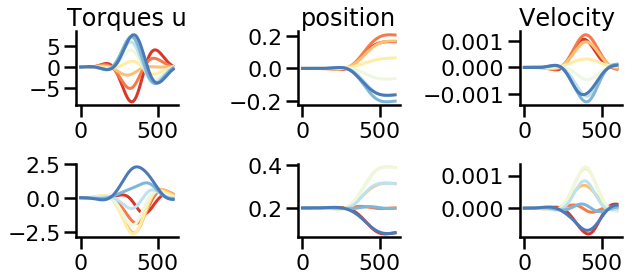

In [210]:
fig, ax = plt.subplots(2,3, figsize=(9,4))
for i in range(2):
    ax[i,0].plot(m[:,:,i].T);
    ax[i,1].plot(q[:,:,i].T);
    ax[i,2].plot(qdot[:,:,i].T)
    
ax[0,0].set_title("Torques u")
ax[0,1].set_title("position")
ax[0,2].set_title("Velocity ")
sns.despine()
fig.tight_layout()

In [211]:
def tangling_t(x, dx, t):
    """ 
    Tangling between state t and s
    x and dx of size (samples, neurons)
    Returns a scalar, tangling of state at time t 
    """
    eps = 1e-10
    return np.mean((dx[t] - dx)**2,axis=1) / (np.mean((x[t]-x)**2, axis=1) + eps)

@jit
def tangling_trials_max(x, dx, t):
    """ Tangling at time t: max over other times"""
    return np.percentile(tangling_trials(x, dx, t),95, axis=1)#.max(1)

# Batch over first dimensions, to generate (trials, time)
tangling_trials = jit(vmap(tangling, (0,0,None)))
# Returns (time, trials time)
tangling_batch = jit(vmap(tangling_trials_max, (None, None, 0)))
X.shape

(8, 600, 6)

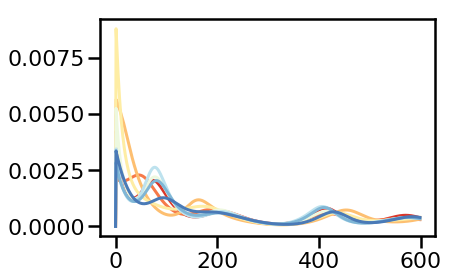

In [212]:
plt.plot(tangling_trials(x, dx,np.array([0])).T);

In [213]:
Qt = tangling_batch(x, dx, np.arange(599))
Qt.shape

(599, 8)

In [218]:
input_strength = np.mean(u_trj[:,:-1]**2, axis=-1)**0.5
torque_strength = np.mean(m[:,:-1]**2, axis=-1)**0.5

242
335


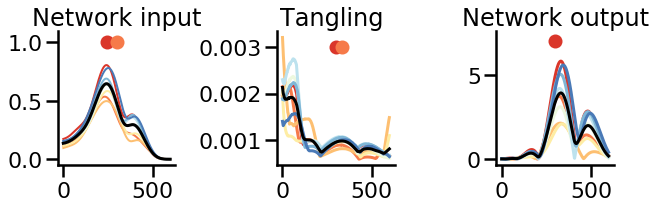

In [219]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[1].plot(Qt);
ax[1].plot(Qt.mean(1), color='black')
ax[0].plot(input_strength.T, lw=2);
ax[0].plot(input_strength.mean(0), color='black', lw=3)
ax[2].plot(torque_strength.T);
ax[2].plot(torque_strength.mean(0), color='black', lw=3)

ax[1].scatter(300, 0.003)
Max_t = np.argmax(input_strength.mean(0))
print(Max_t)
ax[0].scatter(Max_t, 1.0)
ax[0].scatter(300, 1)
Max_t = np.argmax(Qt.mean(1)[200:]) + 200
print(Max_t)
ax[1].scatter(Max_t, 0.003)
M_t = np.argmax(torque_strength.mean(0))
ax[2].scatter(300, 7)

ax[0].set_title("Network input")
ax[1].set_title("Tangling ")
ax[2].set_title("Network output")
sns.despine()
fig.tight_layout()

(8, 598, 2)


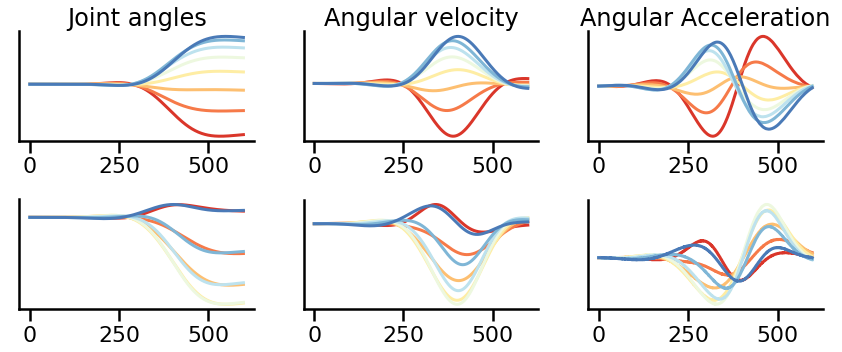

In [236]:
# Can also compute tangling on network angles
fig, ax = plt.subplots(2,3, figsize=(12,5))
thetadotdot = np.diff(theta, axis=1, n=2)
print(thetadotdot.shape)

for i in range(2):
    ax[i,0].plot(theta[:,:,i].T);
    ax[i,1].plot(thetadot[:,:,i].T);
    ax[i,2].plot(thetadotdot[:,:,i].T);
    ax[i,0].set_yticks([])
    ax[i,1].set_yticks([])
    ax[i,2].set_yticks([])

ax[0,0].set_title("Joint angles")
ax[0,1].set_title("Angular velocity")
ax[0,2].set_title("Angular Acceleration")
sns.despine()
fig.tight_layout()

In [488]:
K = np.concatenate((theta, thetadot), axis=2)
dK = np.diff(K, axis=1)
K_tangling = tangling_batch(K[:,:-1], dK, np.arange(599))

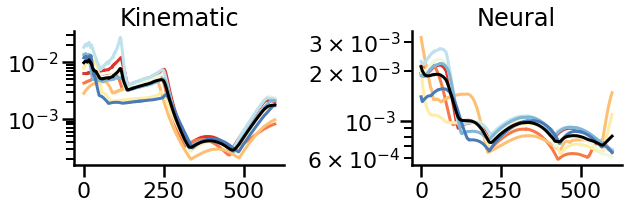

In [417]:
fig, ax = plt.subplots(1,2, figsize=(9,3),sharey=False)
ax[0].semilogy(K_tangling);
ax[0].plot(K_tangling.mean(1), color='black')
ax[1].semilogy(Qt);
ax[1].plot(Qt.mean(1),color='black')

ax[0].set_title("Kinematic")
ax[1].set_title("Neural")

sns.despine()
fig.tight_layout()

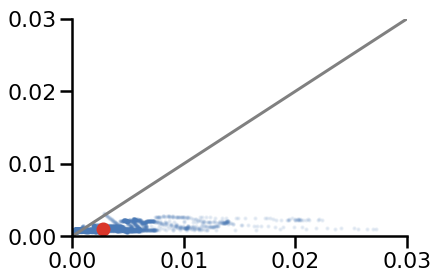

In [409]:
plt.scatter(K_tangling, Qt, s=5, alpha=0.1, color=sns.color_palette("RdYlBu", 8)[-1]);
plt.scatter(K_tangling.mean(), Qt.mean())
plt.plot([0, 0.03], [0, 0.03], color='gray')
plt.xlim([0, 0.03])
plt.ylim([0, 0.03])
sns.despine()

How important is input actually?

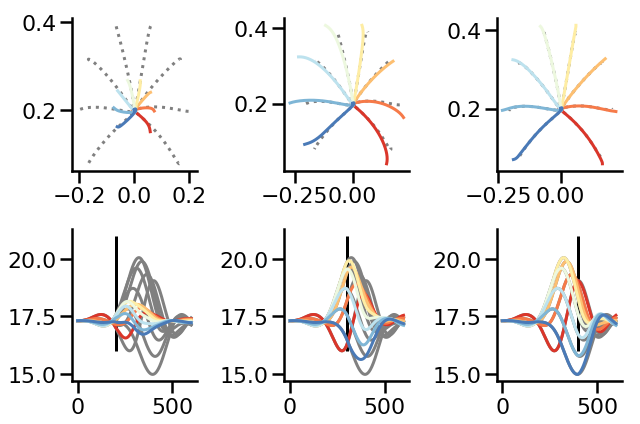

In [407]:
from jax.ops import index_update, index
ts = [200, 300, 400]
fig, ax = plt.subplots(2, len(ts), figsize=(9,6), sharex=False, sharey=False)
y, h, q = network_and_arm.rollout_batch(x_trj[:,0], u_trj)
position = arm_model.get_position_batch(q)

for i in range(len(ts)):
    ax[0,i].plot(position[:,:,0].T, position[:,:,1].T,":", color='gray');
    ax[1,i].plot(h[:,:,0].T, color='gray')


for i, t in enumerate(ts):
    y, h, q = network_and_arm.rollout_batch(x_trj[:,0], index_update(u_trj, index[:,t:,:], 0.0))
    position = arm_model.get_position_batch(q)
    ax[0,i].plot(position[:,:,0].T, position[:,:,1].T);
    ax[1,i].plot(h[:,:,0].T)
    ax[1,i].vlines(t, 16, 21)
    #ax[i].set_title(f"Autnomous after t>{t}", fontsize=10)
    

fig.tight_layout()
sns.despine()

Compare tangling after 400

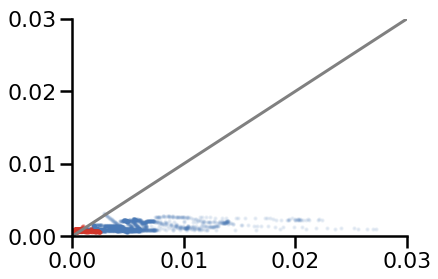

In [415]:
plt.scatter(K_tangling[:300], Qt[:300], s=5, alpha=0.1, color=sns.color_palette("RdYlBu", 8)[-1]);
plt.scatter(K_tangling[300:], Qt[300:], s=5, alpha=0.1, color=sns.color_palette("RdYlBu", 8)[0]);

#plt.scatter(K_tangling.mean(), Qt.mean())
plt.plot([0, 0.03], [0, 0.03], color='gray')
plt.xlim([0, 0.03])
plt.ylim([0, 0.03])
sns.despine()

### Tangling across condition
Wait, but we've only looked at tangling within conditions, not between conditions!

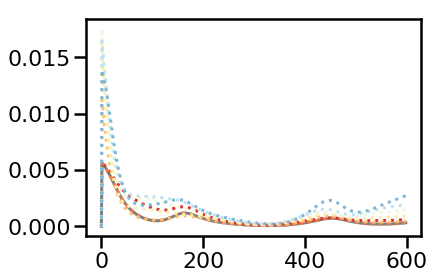

In [433]:
plt.plot(tangling_t(x[2], dx[2], 0), label = 'Within', color='gray')
for i in range(1,8):
    plt.plot(tangling_t(x[2], dx[i], 0),":")

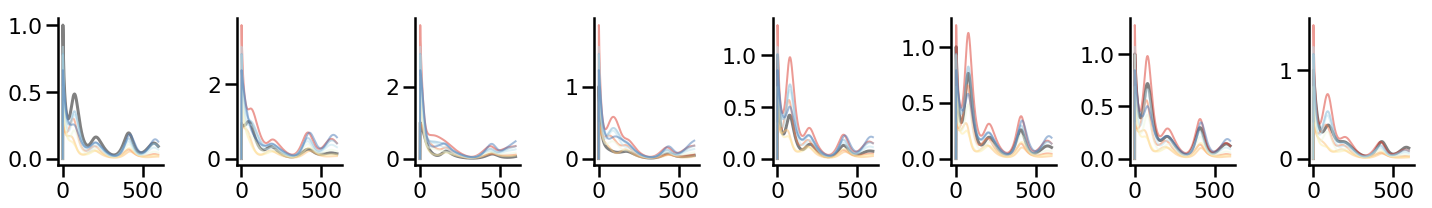

In [540]:
fig, ax = plt.subplots(1, 8, figsize=(20, 3), sharey=False)
for i in range(8):
    T = tangling_t(x[i], dx[i], 0)
    ax[i].plot(T / T.max(), label = 'Within', color='gray')
    for j in [k for k in np.arange(8) if not k==i]:
        ax[i].plot(tangling_t(x[i], dx[j], 0) / T.max(), lw=2, alpha=0.5, color=sns.color_palette("RdYlBu", 8)[j])
sns.despine()
fig.tight_layout()

In [481]:
def tangling_t(x, dx, t):
    """ 
    Tangling between state t and s
    x and dx of size (samples, neurons)
    Returns a scalar, tangling of state at time t 
    """
    eps = 1e-10
    return np.mean((dx[t] - dx)**2,axis=1) / (np.mean((x[t]-x)**2, axis=1) + eps)

# Gives (batch size, batch size, times), where first dim is tangling at time t
# Take maximum over other trials and times
tangling = jit(vmap(vmap(vmap(tangling_t, (None,0,None)), (0,None,None)), (None,None,0)))
Q = tangling(x,dx, np.arange(599))
Qt = Q.max(-1).max(-1)

In [491]:
K = np.concatenate((theta, thetadot), axis=2)
dK = np.diff(K, axis=1)
K_tangling = tangling_batch(K[:,:-1], dK, np.arange(599))
Q_kinematic = tangling(K[:,:-1], dK, np.arange(599))
Qt_kinematic = Q_kinematic.max(-1).max(-1)

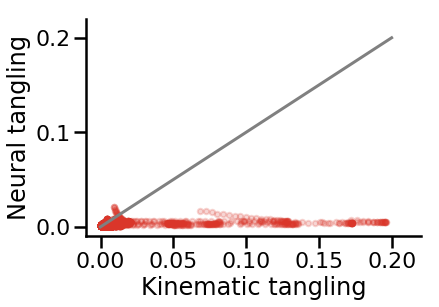

In [533]:
plt.scatter(Qt_kinematic, Qt, alpha=.2, s= 30, facecolor=None)
plt.xlabel("Kinematic tangling")
plt.ylabel("Neural tangling")
plt.xlim([-0.01, 0.22])
plt.ylim([-0.01, 0.22])
plt.plot([0, 0.2], [0, 0.2], color='gray')
sns.despine()

In [534]:
Q_kinematic.shape

(599, 8, 8, 599)

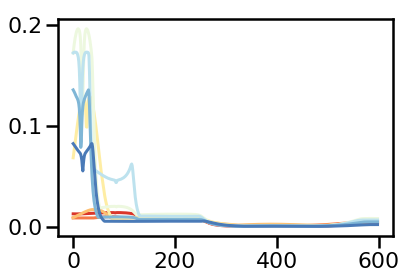

In [538]:
plt.plot(Qt_kinematic)